# Mobile Application Analysis

## Project description and objective

 Identify the characteristics of user behavior of a startup's mobile app selling food products:
 - sales funnel
 - A/A/B test results

## Data description 

- EventName - the name of the event;
- DeviceIDHash - unique user identifier;
- EventTimestamp - time of the event;
- ExpId - experiment number: 246 and 247 are control groups, and 248 is the experimental group.

## Plan 

1. Data preprocessing and validation
2. Analyzing the sales funnel
3. Analyzing the results of experiment A/A/B test
4. Overall conclusion

## Project 

### Data preprocessing and validation

In [171]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
import math as mth
from IPython.display import display

In [172]:
data = pd.read_csv('logs_exp.csv',  sep = '\t')


In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [174]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [175]:
#column rename
data = data.rename (columns = {'EventName' : 'event_name', 'DeviceIDHash' : 'device_id', 'EventTimestamp' : 'event_ts', 'ExpId' :'exp_id'})

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   device_id   244126 non-null  int64 
 2   event_ts    244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [134]:
#no missing values, data type in the date column needs to be changed

In [135]:
# сhange the data type in the column with date and time information
# add a column with date
data['event_ts'] = pd.to_datetime(data['event_ts'], unit='s')

In [136]:
data['event_date'] = data['event_ts'].dt.floor('d')

In [137]:
data.head()

,event_name,device_id,event_ts,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [138]:
#check for explicit duplicates
data.duplicated().sum()

413

In [139]:
#remove all excplicit duplicates
data = data.drop_duplicates().reset_index(drop = True)
data.duplicated().sum()

0

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_ts    243713 non-null  datetime64[ns]
 3   exp_id      243713 non-null  int64         
 4   event_date  243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


### Sales funnel analysis

In [141]:
#number of events in the log
event_count = data['event_name'].count()
event_count

243713

**The number of events in the log is 243713 after removing explicit duplicates.**

In [142]:
#number of unique users in the log 
user_count = data['device_id'].nunique()
user_count

7551

In [143]:
#average number of events per user
event_per_user = event_count/user_count
event_per_user.round()

32.0

In [144]:
#minimum date of events in the log
date_min = data['event_ts'].min()
date_min

Timestamp('2019-07-25 04:43:36')

In [145]:
#maximun date of events in the log
date_max = data['event_ts'].max()
date_max

Timestamp('2019-08-07 21:15:17')

**The data contains records of events in the application starting from July 25, 2019, and ending on August 7, 2019.**

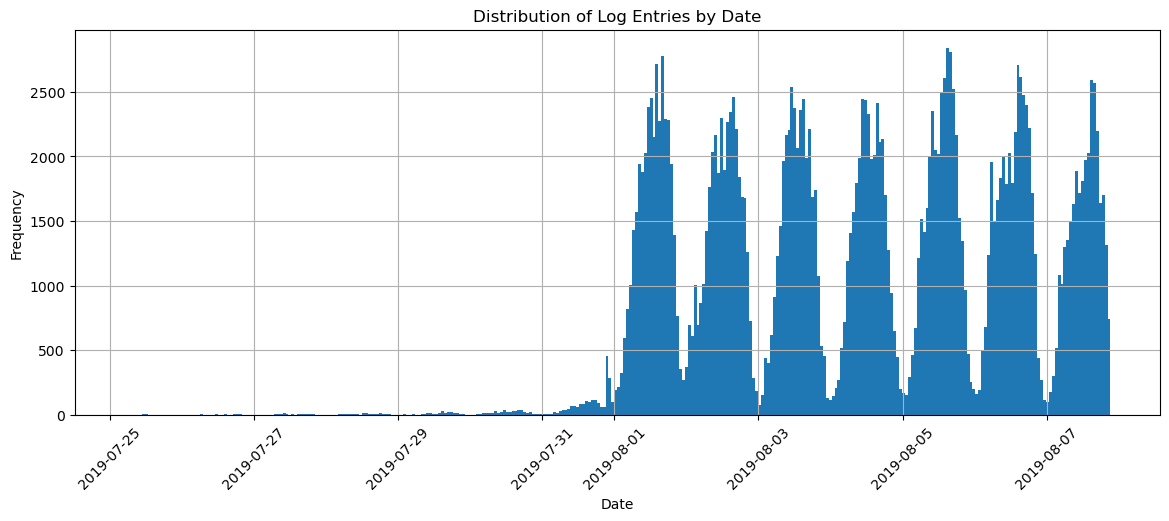

In [146]:
#histogram showing the distribution of events in the log by date.
data['event_ts'].hist(bins=14*24, figsize=(14, 5))
plt.title('Distribution of Log Entries by Date')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation = 45);

**Around July 31st and August 1st, we observe a sharp increase in the number of events in the log. Let's check the event count depending on the date:**

In [147]:

event_group = data.pivot_table(index = 'event_date', values = 'event_name', aggfunc = 'count' )
event_group


,event_name
event_date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


**We can see that the number of events (observations) sharply increases on August 1st. For further analysis, we will use data recorded from August 1st. To do this, we will make a slice and create a new table:**

In [148]:
#making a slice and checking the minimum date again:
data_new = data.query ('event_date > 20190731')
data_new['event_date'].min()

Timestamp('2019-08-01 00:00:00')

In [149]:
#checking the number of events and users in the table with up-to-date data:
event_count_new = data_new['event_name'].count()
event_count_new

240887

In [150]:
user_count_new = data_new['device_id'].nunique()
user_count_new

7534

In [151]:
#calculating losses of discarded data (events) and unique users in absolute terms after filtering out events before August 1st

In [152]:
events_loss_abs = event_count - event_count_new
events_loss_abs

2826

In [153]:
users_loss_abs = user_count - user_count_new
users_loss_abs

17

In [154]:
#calculating the proportion of discarded data (events) and unique users after filtering out events before August 1st

In [155]:
events_loss = (1 - event_count_new/event_count)*100
events_loss

1.159560630741896

In [156]:
users_loss = (1- user_count_new/user_count)*100
users_loss

0.22513574361011646

**After cleaning the data, we lost less than 1% of unique users and 1% of events in the log. In absolute terms it is 2826 events and 17 unique users, respectively**

In [157]:
#сhecking the distribution of users across groups:
users_by_exp_group = data_new.groupby('exp_id').agg({'device_id' : 'nunique'})
users_by_exp_group

,device_id
exp_id,
246,2484
247,2513
248,2537


There are users in each group 

In [158]:
#checking which events are present in the log and how often they occur.
#funnel_events = data.groupby('event_name').agg({'device_id': 'count'}).sort_values(by = 'device_id', ascending = False)

#funnel_events

In [159]:
#number of users who performed each of the events in the log
#funnel_users = data.groupby('event_name').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False)
#funnel_users

In [160]:
#merging the tables and finding the proportion of users who performed at least one event
#funnel = funnel_events.merge(funnel_users, on = 'event_name')
#funnel.columns = ['events_count', 'users_count']
#funnel

In [161]:
funnel = data.groupby('event_name').agg(events_count=('device_id', 'count'),
                                         users_count=('device_id', 'nunique')).sort_values(by='events_count', ascending=False)
funnel


,events_count,users_count
event_name,,
MainScreenAppear,119101,7439
OffersScreenAppear,46808,4613
CartScreenAppear,42668,3749
PaymentScreenSuccessful,34118,3547
Tutorial,1018,847


In [162]:
#proportion of users who performed at least one action in the funnel
funnel ['ratio_user_event_all_users'] = funnel['users_count']/user_count_new
funnel.style.format({'ratio_user_event_all_users' :'{:.2%}'})

,events_count,users_count,ratio_user_event_all_users
event_name,,,
MainScreenAppear,119101,7439,98.74%
OffersScreenAppear,46808,4613,61.23%
CartScreenAppear,42668,3749,49.76%
PaymentScreenSuccessful,34118,3547,47.08%
Tutorial,1018,847,11.24%


**Sequence of steps in the funnel:**
One could assume that the sequence of steps in the funnel is as follows:
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful

The Tutorial event was completed by 11% of users. This is less than the number of people who made a purchase, so we assume that this event does not affect payment and will remove it from the funnel.

In [163]:
#removing all Tutorial events
funnel = funnel.drop(index = 'Tutorial')
funnel

,events_count,users_count,ratio_user_event_all_users
event_name,,,
MainScreenAppear,119101,7439,0.987390
OffersScreenAppear,46808,4613,0.612291
CartScreenAppear,42668,3749,0.497611
PaymentScreenSuccessful,34118,3547,0.470799


In [164]:
#calculating the conversion rate for each step.
funnel['conversion_step_1'] = funnel['users_count'].pct_change().fillna(0)+1
funnel['conversion_step'] = funnel['users_count']/funnel['users_count'].shift(periods=1, freq=None, axis=0, fill_value=7439)
funnel.style.format({'ratio_user_event_all_users' :'{:.2%}', 'conversion_step' : '{:.2%}'})
funnel

,events_count,users_count,ratio_user_event_all_users,conversion_step_1,conversion_step
event_name,,,,,
MainScreenAppear,119101,7439,0.987390,1.000000,1.000000
OffersScreenAppear,46808,4613,0.612291,0.620110,0.620110
CartScreenAppear,42668,3749,0.497611,0.812703,0.812703
PaymentScreenSuccessful,34118,3547,0.470799,0.946119,0.946119


In [165]:
#restoring the indices to the table
funnel = funnel.reset_index()
funnel

,event_name,events_count,users_count,ratio_user_event_all_users,conversion_step_1,conversion_step
0,MainScreenAppear,119101,7439,0.987390,1.000000,1.000000
1,OffersScreenAppear,46808,4613,0.612291,0.620110,0.620110
2,CartScreenAppear,42668,3749,0.497611,0.812703,0.812703
3,PaymentScreenSuccessful,34118,3547,0.470799,0.946119,0.946119


In [166]:
#calculating standart conversion
funnel['conversion'] = funnel['users_count']/funnel.loc[0, 'users_count']
funnel.style.format({'ratio_user_event_all_users' :'{:.2%}', 'conversion_step' : '{:.2%}', 'conversion' : '{:.2%}'})
funnel

,event_name,events_count,users_count,ratio_user_event_all_users,conversion_step_1,conversion_step,conversion
0,MainScreenAppear,119101,7439,0.987390,1.000000,1.000000,1.000000
1,OffersScreenAppear,46808,4613,0.612291,0.620110,0.620110,0.620110
2,CartScreenAppear,42668,3749,0.497611,0.812703,0.812703,0.503966
3,PaymentScreenSuccessful,34118,3547,0.470799,0.946119,0.946119,0.476811


In [169]:
#conversion graph
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['users_count']))


fig.update_layout(title="Conversion",
                  xaxis_title="Number of Users")

fig.show()

In [170]:
#conversion to step graph
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['conversion_step_1']))


fig.update_layout(title="Conversion to step"
                  )

fig.show()

**Conclusion**
1. From the initial event (main screen view) to payment, 47% of users proceed.
2. The largest drop-off in users occurs when transitioning from the main screen to the special offers page.


###  A/B test analysis

#### Number of users in each experimental group

In [98]:
#finding the number of participants in each experimental group:
users_by_exp_group = data_new.groupby('exp_id').agg({'device_id' : 'nunique'})
users_by_exp_group ['ratio'] = users_by_exp_group['device_id']/users_by_exp_group['device_id'].sum()
users_by_exp_group

,device_id,ratio
exp_id,,
246,2484,0.329705
247,2513,0.333555
248,2537,0.336740


Conclusion: Distribution into groups is uniform. The difference between the groups is less than 1 p.p.

#### Finding the statistical difference between groups 246 and 247

In [99]:
#grouping the data by experimental groups, events, and the number of unique users for each group and event
data_exp_group = data_new.pivot_table (index = 'event_name', columns = 'exp_id', values = 'device_id', aggfunc = 'nunique')
data_exp_group

exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


In [100]:
data_exp_group ['total'] = data_exp_group.sum(axis = 1)
data_exp_group

exp_id,246,247,248,total
event_name,,,,
CartScreenAppear,1266,1238,1230,3734
MainScreenAppear,2450,2476,2493,7419
OffersScreenAppear,1542,1520,1531,4593
PaymentScreenSuccessful,1200,1158,1181,3539
Tutorial,278,283,279,840


In [101]:
# all events in the Tutorial category have been removed
data_exp_group = data_exp_group.drop(index = 'Tutorial')
data_exp_group

exp_id,246,247,248,total
event_name,,,,
CartScreenAppear,1266,1238,1230,3734
MainScreenAppear,2450,2476,2493,7419
OffersScreenAppear,1542,1520,1531,4593
PaymentScreenSuccessful,1200,1158,1181,3539


In [102]:
# defining variables for calculating the statistical difference between groups 246 and 247
#leads - the number of participants in the experiment at the beginning of the test, purchases - users who made a purchase
purchases_246 = data_exp_group.loc['PaymentScreenSuccessful', 246]
purchases_246

1200

In [103]:
purchases_247 = data_exp_group.loc['PaymentScreenSuccessful', 247]
purchases_247

1158

In [104]:
leads_246 = users_by_exp_group.loc[246, 'device_id']
leads_246

2484

In [105]:
leads_247 = users_by_exp_group.loc[247, 'device_id']
leads_247

2513

In [106]:
purchases = np.array([purchases_246, leads_246])

purchases

array([1200, 2484])

In [107]:
leads = np.array ([leads_246, leads_247])

In [108]:
#checking for the presence/absence of statistically significant difference between groups 246 and 247

alpha = 0.05 # critical level of statistical significance


purchases = np.array([purchases_246, purchases_247])
leads = np.array ([leads_246, leads_247])


p1 = purchases[0]/leads[0]

p2 = purchases[1]/leads[1]

p_combined = (purchases[0] + purchases[1]) / (leads [0] + leads [1])

difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if p_value < alpha:
    print('We reject the null hypothesis: there is a significant difference between the proportions')
else:
    print(
        'We failed to reject the null hypothesis; there is no evidence to consider the proportions different.'
    ) 



p-value:  0.11456679313141849
We failed to reject the null hypothesis; there is no evidence to consider the proportions different.


**Conclusion:**
There is no statistically significant difference between control groups 246 and 247

#### Checking the statistical significance of the difference between the most popular event and all other events in the groups:

In [109]:
#defining the most popular event
data_pop_event = data_exp_group.sort_values(by = 'total', ascending = False)
data_pop_event


exp_id,246,247,248,total
event_name,,,,
MainScreenAppear,2450,2476,2493,7419
OffersScreenAppear,1542,1520,1531,4593
CartScreenAppear,1266,1238,1230,3734
PaymentScreenSuccessful,1200,1158,1181,3539


**Conclusion:** The most popular event for all participants in the experiment is MainScreenAppear. This confirms the normalcy of the funnel we described earlier. The majority of participants in the experiment are at the first step of the funnel.

In [110]:
# finding the proportions of users who completed all 4 types of events in each of the three groups
data_pop_event['ratio_246'] = data_pop_event[246]/data_pop_event[246].sum()
data_pop_event['ratio_247'] = data_pop_event[247]/data_pop_event[247].sum()
data_pop_event['ratio_248'] = data_pop_event[248]/data_pop_event[248].sum()
data_pop_event

exp_id,246,247,248,total,ratio_246,ratio_247,ratio_248
event_name,,,,,,,
MainScreenAppear,2450,2476,2493,7419,0.379374,0.387359,0.387413
OffersScreenAppear,1542,1520,1531,4593,0.238774,0.237797,0.237918
CartScreenAppear,1266,1238,1230,3734,0.196036,0.193680,0.191142
PaymentScreenSuccessful,1200,1158,1181,3539,0.185816,0.181164,0.183528


In [111]:
# creating a combined group 246+247 and name it 250
data_pop_event[250] = data_pop_event[246]+data_pop_event[247]
data_pop_event

exp_id,246,247,248,total,ratio_246,ratio_247,ratio_248,250
event_name,,,,,,,,
MainScreenAppear,2450,2476,2493,7419,0.379374,0.387359,0.387413,4926
OffersScreenAppear,1542,1520,1531,4593,0.238774,0.237797,0.237918,3062
CartScreenAppear,1266,1238,1230,3734,0.196036,0.193680,0.191142,2504
PaymentScreenSuccessful,1200,1158,1181,3539,0.185816,0.181164,0.183528,2358


In [112]:
# keeping in the table only the values necessary for conducting the z-test
data_for_test = data_pop_event[[ 246, 247, 248, 250]]
data_for_test

exp_id,246,247,248,250
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [113]:
# adding to the table the breakdown of test participants by groups, including data for group 250.
users_by_exp_group.loc[250] = (users_by_exp_group.loc[246, 'device_id'] 
                                 + users_by_exp_group.loc[247, 'device_id'])

users_by_exp_group



,device_id,ratio
exp_id,,
246,2484,0.329705
247,2513,0.333555
248,2537,0.336740
250,4997,4997.000000


To test the statistical difference between proportions, we will create a function. We plan to test 4 groups for 4 events: 246 and 247, 246 and 248, 247 and 248, 250 and 248. This amounts to 16 tests. We will again use the z-test, but this time we will apply the Bonferroni correction, which equals alpha/16, for the number of tests.


**Null Hypothesis:** The proportions of unique visitors who visited each stage of the funnel are the same.
**Alternative Hypothesis:** There is a significant difference between the proportions of unique visitors who visited each stage of the funnel.

In [123]:
#create a function to calculate the difference between proportions

alpha = .05 # critical level of statistical significance

def check_equal_z_test_bonf (group1, group2, event, alpha): 
    p1_event = data_for_test.loc[event, group1]
    p2_event = data_for_test.loc[event, group2] 
    p1_users = users_by_exp_group.loc[group1, 'device_id'] 
    p2_users = users_by_exp_group.loc[group2, 'device_id'] 
    p1 = p1_event / p1_users 
    p2 = p2_event / p2_users 
    difference = p1 - p2
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    bonferroni_alpha = alpha / 16
    
    print('Checking for groups {} and {}, event: {}, p-value: {:.2f}'.format(group1, group2, event, p_value))
    if (p_value < bonferroni_alpha):
        print("Reject the null hypothesis: there is a significant difference between the proportions")
    else:
        print("Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different")

In [124]:
#conducting the test for groups 246 and 247.
for event in data_for_test.index:
    check_equal_z_test_bonf(246, 247, event, 0.05)
    print()

Checking for groups 246 and 247, event: MainScreenAppear, p-value: 0.76
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 246 and 247, event: OffersScreenAppear, p-value: 0.25
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 246 and 247, event: CartScreenAppear, p-value: 0.23
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 246 and 247, event: PaymentScreenSuccessful, p-value: 0.11
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different



**Conclusion:** conducting a z-test with Bonferroni correction, we did not detect statistically significant differences between groups 246 and 247, unlike the z-test we previously conducted for groups 246 and 247 without correction.

In [125]:
#conducting the test for groups 246 and 248
for event in data_for_test.index:
    check_equal_z_test_bonf(246, 248, event, 0.05)
    print()

Checking for groups 246 and 248, event: MainScreenAppear, p-value: 0.29
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 246 and 248, event: OffersScreenAppear, p-value: 0.21
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 246 and 248, event: CartScreenAppear, p-value: 0.08
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 246 and 248, event: PaymentScreenSuccessful, p-value: 0.21
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different



In [126]:
#conducting the test for groups 247 and 248
for event in data_for_test.index:
    check_equal_z_test_bonf(247, 248, event, 0.05)
    print()

Checking for groups 247 and 248, event: MainScreenAppear, p-value: 0.46
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 247 and 248, event: OffersScreenAppear, p-value: 0.92
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 247 and 248, event: CartScreenAppear, p-value: 0.58
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 247 and 248, event: PaymentScreenSuccessful, p-value: 0.74
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different



In [127]:
#conducting the test for groups 248 and 250
for event in data_for_test.index:
    check_equal_z_test_bonf(248, 250, event, 0.05)
    print()

Checking for groups 248 and 250, event: MainScreenAppear, p-value: 0.29
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 248 and 250, event: OffersScreenAppear, p-value: 0.43
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 248 and 250, event: CartScreenAppear, p-value: 0.18
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different

Checking for groups 248 and 250, event: PaymentScreenSuccessful, p-value: 0.60
Failed to reject the null hypothesis, there is no evidence to suggest the proportions are different



#### The choice of the level of statistical significance

To find differences between control and experimental groups, we chose the z-test, setting the value for alpha at 0.05 and using the Bonferroni correction equal to the number of comparisons conducted - 16.

### Final conclusion

In this project, we analyzed the results of an A/A/B test conducted for a mobile application. The control groups (246 and 247) saw the version of the application without font changes, while the experimental group (248) saw the version with font changes.

 - For analysis, we have data from June 25, 2019, to August 7, 2019. To analyze the test results, we used data from August 1st to 8th, as the data from July 25th to 31st is incomplete.
 - After data cleaning, we lost less than 1% of unique users and 1% of events in the log.
 - In the sales funnel and test analysis, we do not consider the Tutorial event as it is the least significant among all events and does not affect the outcome - completing the payment.
 - 47% of users proceed from the first event (main screen view) to payment.
 - The largest number of users is lost when transitioning from the main screen to the special offers page.
 - The distribution into test groups is even. The difference between groups is less than 1 percentage point.
 - Analysis of the A/A/B test results did not reveal significant differences between the control and experimental groups. It can be concluded that the font styles used for the test did not affect user behavior in the application. 
